# image segmentation
on the U-net model

https://towardsdatascience.com/train-neural-net-for-semantic-segmentation-with-pytorch-in-50-lines-of-code-830c71a6544f this person has many other cool tutorials on https://medium.com/@sagieppel

Uses the [Vector-LabPics](https://zenodo.org/record/3697452#.YmPjLBxByEJ) dataset which annotates cups (vessels) and liquids (filled). Get U-net model pretrained on the COCO dataset, change the final layer, and re-train it on the new dataset.

https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/ -> paywalled....

In [1]:
import os
import numpy as np
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as transforms

from matplotlib import pyplot as plt

learning_rate = 1e-5
width=height = 900
batch_size = 3

load images

In [2]:
trainFolder = "LabPicsV1/Simple/Train"
listImages = os.listdir(os.path.join(trainFolder, "Image"))


define transformations for image and annotation

In [3]:
transformImg = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((height, width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transformAnnot = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((height, width)),
    transforms.ToTensor()
])

In [4]:
def readRandomImage():
    idx = np.random.randint(0, len(listImages))
    img = cv2.imread(os.path.join(trainFolder, "Image", listImages[idx]))
    # load the annotation
    filled = cv2.imread(os.path.join(trainFolder, "Semantic/16_Filled", listImages[idx].replace("jpg", "png")), 0)
    vessel = cv2.imread(os.path.join(trainFolder, "Semantic/1_Vessel", listImages[idx].replace("jpg", "png")), 0)
    # 0 is background, 1 is filled, 2 is vessel
    annotationMap = np.zeros((img.shape[0:2]), dtype=np.float32)
    if filled is not None:
        annotationMap[vessel == 1] = 1
    if vessel is not None:
        annotationMap[filled == 1] = 2
    img = transformImg(img)
    annotationMap = transformAnnot(annotationMap)
    return img, annotationMap

show an image and its annotation, as a sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


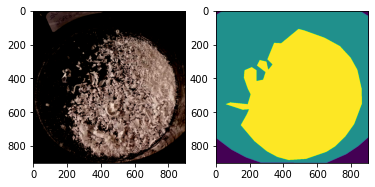

In [5]:
img, annot = readRandomImage()
plt.subplot(1, 2, 1)
img_rgb = cv2.cvtColor(img.permute(1,2,0).numpy(), cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb / np.max(img_rgb))  # normalize to 0-1
plt.subplot(1, 2, 2)
plt.imshow(annot.permute(1, 2, 0))
plt.show()

In [6]:
def loadBatch():
    images = torch.zeros((batch_size, 3, height, width))
    annotations = torch.zeros((batch_size, height, width))
    for i in range(batch_size):
        images[i], annotations[i] = readRandomImage()
    return images, annotations

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Deeplabv3 is "one of the best segmentation nets"
# pretrained on the COCO dataset
net = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)

# change final layer to 4 classes
net.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))

# load it to the device
net = net.to(device)

# create Adam optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

In [8]:
# show information about the model
print(net)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [9]:
def inferAndVisualize(img):
    net.eval()
    with torch.no_grad():
        pred = net(img.unsqueeze(0).to(device))['out']
    pred = torch.argmax(pred, dim=1)
    plt.subplot(1, 2, 1)
    plt.imshow(img.permute(1, 2, 0).numpy() / np.max(img.permute(1, 2, 0).numpy()))
    plt.subplot(1, 2, 2)
    plt.imshow(pred.permute(1, 2, 0))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


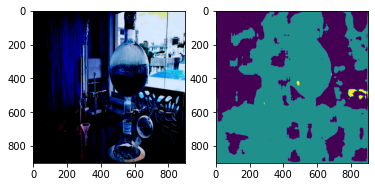

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [10]:
net.eval()

# show model output before training, as a joke
img, _ = readRandomImage()
inferAndVisualize(img)

net.train()

In [11]:
loss_history = []
for i in range(31):
    images, annotations = loadBatch()
    # convert data to gradient variables that can be used by the network.
    # the gradient is applied to the network parameters, not to the image, so requires_grad set to False
    images = torch.autograd.Variable(images, requires_grad=False).to(device)
    annotations = torch.autograd.Variable(annotations, requires_grad=False).to(device)
    pred = net(images)['out']
    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(pred, annotations.long())
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if i % 10 == 0:
        model_name = f"step{i}.pth"
        print(f"saving model to {model_name}")
        torch.save(net.state_dict(), model_name)

saving model to step0.pth
saving model to step10.pth


[ WARN:0@609.858] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('LabPicsV1/Simple/Train/Semantic/16_Filled/vacuumdistillation_Insta_Screenshot (28).png'): can't open/read file: check file path/integrity
[ WARN:0@684.683] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('LabPicsV1/Simple/Train/Semantic/1_Vessel/IMG_20190117_112040.png'): can't open/read file: check file path/integrity


saving model to step20.pth
saving model to step30.pth


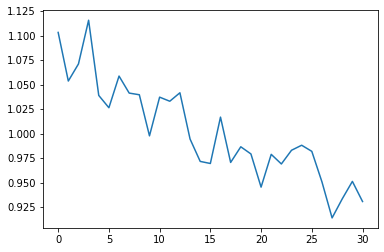

In [12]:
plt.plot(loss_history)
plt.show()

## run inference on the resulting model

torch.Size([3, 900, 900])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


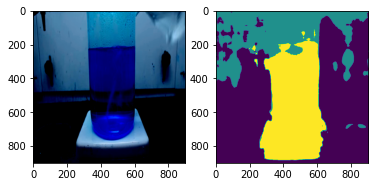

In [16]:
model_name = "step30.pth"
net.load_state_dict(torch.load(model_name))

img_name = "LabPicsV1/Simple/Test/Image/NileRed_How to make P-Nitroaniline-screenshot (8).jpg"
img = cv2.imread(img_name)

img = transformImg(img)
print(img.shape)

net.eval()
inferAndVisualize(img)